In [1]:
import pandas
import datetime
import math
import os
import numpy
from scipy import signal, ndimage, stats
from scipy.optimize import curve_fit
from davitpy.models import *
from davitpy import utils
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
import seaborn as sns
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Some constants
equTrghCutoffMLat = 40.
polTrghCutoffMLat = 70.
# We'll only look at NA continent, So we 
# choose the corresponding MLONS - 260, 20
mlonNAList = range( -180, 181, 2 )#range( -100, 21, 2 )
# Some cutoffs to verify goodness of fit
cutoffKSPval = 0.7
cutoffKSDstat = 0.25
cutOffTrghMinUpper = 65.
cutOffTrghMinLower = 45.
cutOffPrcntErrorFit = 0.1 # 10%
cutOffLatCnt = 20
cutOffMinTECVal = 4.

In [3]:
def convert_to_datetime(row):
    currDateStr = str( int( row["dateStr"] ) )
#     return currDateStr
    if row["timeStr"] < 10:
        currTimeStr = "000" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 100:
        currTimeStr = "00" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 1000:
        currTimeStr = "0" + str( int( row["timeStr"] ) )
    else:
        currTimeStr = str( int( row["timeStr"] ) )
    return datetime.datetime.strptime( currDateStr\
                    + ":" + currTimeStr, "%Y%m%d:%H%M" )

selDT = datetime.datetime( 2011, 4, 9, 8, 40 )
anlyzCoords = 'mag'

In [4]:
inpColList = [ "dateStr", "timeStr", "Mlat",\
              "Mlon", "med_tec", "dlat", "dlon" ]
inpFile = "../data/tec-medFilt-20110409.txt"
medFiltTECDF = pandas.read_csv(inpFile, delim_whitespace=True,\
                                    header=None, names=inpColList)
medFiltTECDF["date"] = medFiltTECDF.apply( convert_to_datetime, axis=1 )
medFiltTECDF.head()

,dateStr,timeStr,Mlat,Mlon,med_tec,dlat,dlon,date
0,20110409,10,11.0,32.0,7.7,1.0,2.0,2011-04-09 00:10:00
1,20110409,10,11.0,34.0,8.7,1.0,2.0,2011-04-09 00:10:00
2,20110409,10,11.0,36.0,9.3,1.0,2.0,2011-04-09 00:10:00
3,20110409,10,11.0,66.0,14.3,1.0,2.0,2011-04-09 00:10:00
4,20110409,10,11.0,68.0,14.7,1.0,2.0,2011-04-09 00:10:00


In [5]:
# print medFiltTECDF["timeStr"].unique()

In [6]:
# Analyze the selected time
selTecDF = medFiltTECDF[ medFiltTECDF["date"] == selDT ].reset_index(drop=True)
selTecDF.head()

,dateStr,timeStr,Mlat,Mlon,med_tec,dlat,dlon,date
0,20110409,840,11.0,2.0,1.5,1.0,2.0,2011-04-09 08:40:00
1,20110409,840,11.0,68.0,22.2,1.0,2.0,2011-04-09 08:40:00
2,20110409,840,11.0,70.0,28.7,1.0,2.0,2011-04-09 08:40:00
3,20110409,840,11.0,72.0,30.2,1.0,2.0,2011-04-09 08:40:00
4,20110409,840,11.0,74.0,31.5,1.0,2.0,2011-04-09 08:40:00


In [7]:
def gauss_function(x, a, x0, sigma):
    return a*numpy.exp(-(x-x0)**2/(2*sigma**2))

In [8]:
BndMlonArr = []
BndEquMlatArr = []
BndPolMlatArr = []
minTecMlatArr = []
minTecValArr = []
BndEquTecValArr = []
BndPolTecValArr = []
currTimeArr = []
selMlonList = [ 300., 320., 20., 80. ]
for ind, sMlon in enumerate(mlonNAList):
    if sMlon < 0.:
        sMlon = sMlon + 360.
    selMlonDF = selTecDF[ (selTecDF["Mlon"] == sMlon) &\
                          (selTecDF["Mlat"] >= equTrghCutoffMLat) &\
                          (selTecDF["Mlat"] <= polTrghCutoffMLat)]
    # If no significant number of values are found discard
    if len( selMlonDF["med_tec"].values ) < 5.:
        continue
    tecGaussFitArr = numpy.max( selMlonDF["med_tec"].values ) - selMlonDF["med_tec"].values
    mlatPltArr = numpy.arange(equTrghCutoffMLat-20, polTrghCutoffMLat+20)
    try:
        popt, pcov = curve_fit(gauss_function, selMlonDF["Mlat"].values,\
                               tecGaussFitArr, p0 = [2, 52., 1.])
    except:
#         print "failed fit at MLON-->", sMlon
        continue
    fwhmEqu = popt[1] - popt[2]*2.355/2.
    fwhmPol = popt[1] + popt[2]*2.355/2.
    tecValFwhmEqu = gauss_function(fwhmEqu, *popt)
    tecValFwhmPol = gauss_function(fwhmPol, *popt)
    # Test goodness of fit
    ksTestTecArr = numpy.array( [ gauss_function(l, *popt)\
                                for l in selMlonDF["Mlat"].values.tolist() ] )
    ksDStat, ksPVal = stats.ks_2samp( tecGaussFitArr, ksTestTecArr )
    # we setup a few conditions to discard bad fits
    # 1) location of trough min should be between 45 nad 65 MLAT
    if ((popt[1] > cutOffTrghMinUpper)\
            | (popt[1] < cutOffTrghMinLower)):
        continue
    # 2) if percent error in any of fit parameters is more 
    # than 10 % (cutoff) then skip
    if ( ( pcov[0,0]**0.5/popt[0] > cutOffPrcntErrorFit  ) \
        | ( pcov[1,1]**0.5/popt[1] > cutOffPrcntErrorFit  ) \
        | ( pcov[2,2]**0.5/popt[2] > cutOffPrcntErrorFit  ) ):
        continue
    # 3) Number of latitudes should be greater than 20.
    if len( selMlonDF["Mlat"].values ) < cutOffLatCnt:
        continue
    # 4) If p-val from the KS TEST is low discard
    # or if KS Stat is high discard
    if ksPVal < cutoffKSPval:
        continue
    if ksDStat > cutoffKSDstat:
        continue
    # 5) if tec value at min trough is greater than 4.
    # discard
    # GET Trough min loc and tec val
    minTrghLoc = min(list(selMlonDF["Mlat"].values), key=lambda x:abs(x-popt[1]))
    minTrghTecVal = selMlonDF[ selMlonDF["Mlat"] == minTrghLoc ]["med_tec"].values[0]
    # GET Trough equ loc and tec val
    equTrghLoc = min(list(selMlonDF["Mlat"].values), key=lambda x:abs(x-fwhmEqu))
    equTrghTecVal = selMlonDF[ selMlonDF["Mlat"] == equTrghLoc ]["med_tec"].values[0]
    # GET Trough pol loc and tec val
    polTrghLoc = min(list(selMlonDF["Mlat"].values), key=lambda x:abs(x-fwhmPol))
    polTrghTecVal = selMlonDF[ selMlonDF["Mlat"] == polTrghLoc ]["med_tec"].values[0]
    if minTrghTecVal > cutOffMinTECVal:
        continue
    # Now we have good fits. Get appropriate boundary locations
    # and TEC values.
    # Append the values to arrays
    BndMlonArr.append( sMlon )
    BndEquMlatArr.append( equTrghLoc )
    BndPolMlatArr.append( polTrghLoc )
    minTecMlatArr.append( minTrghLoc )
    minTecValArr.append( minTrghTecVal )
    BndEquTecValArr.append( equTrghTecVal )
    BndPolTecValArr.append( polTrghTecVal )
    currTimeArr.append( selDT )
# Store data in a DF
trghBndDF = pandas.DataFrame({
            "BndMlon" : BndMlonArr,
            "BndEquMlat" : BndEquMlatArr,
            "BndPolMlat" : BndPolMlatArr,
            "minTecMlat" : minTecMlatArr,
            "minTecVal" : minTecValArr,
            "BndEquTecVal" : BndEquTecValArr,
            "BndPolTecVal" : BndPolTecValArr,
            "date" : currTimeArr
            })
trghBndDF.head()

/usr/local/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in double_scalars


,BndEquMlat,BndEquTecVal,BndMlon,BndPolMlat,BndPolTecVal,date,minTecMlat,minTecVal
0,66.0,7.8,244.0,56.0,8.4,2011-04-09 08:40:00,61.0,3.0
1,54.0,9.8,246.0,68.0,7.6,2011-04-09 08:40:00,61.0,3.5
2,54.0,8.8,252.0,68.0,7.4,2011-04-09 08:40:00,61.0,3.3
3,53.0,8.9,254.0,67.0,7.9,2011-04-09 08:40:00,60.0,2.9
4,54.0,8.0,256.0,66.0,8.5,2011-04-09 08:40:00,60.0,3.1


In [9]:
print trghBndDF

    BndEquMlat  BndEquTecVal  BndMlon  BndPolMlat  BndPolTecVal  \
0         66.0           7.8    244.0        56.0           8.4   
1         54.0           9.8    246.0        68.0           7.6   
2         54.0           8.8    252.0        68.0           7.4   
3         53.0           8.9    254.0        67.0           7.9   
4         54.0           8.0    256.0        66.0           8.5   
5         53.0           8.2    258.0        66.0           8.2   
6         54.0           7.5    264.0        66.0           5.9   
7         54.0           7.4    266.0        66.0           7.0   
8         54.0           7.4    268.0        65.0           7.7   
9         49.0           7.5    310.0        63.0           9.2   
10        49.0           6.6    312.0        62.0           8.9   
11        48.0           9.6    318.0        66.0           7.9   
12        50.0           9.1    322.0        67.0           7.4   
13        51.0           9.1    324.0        67.0           7.

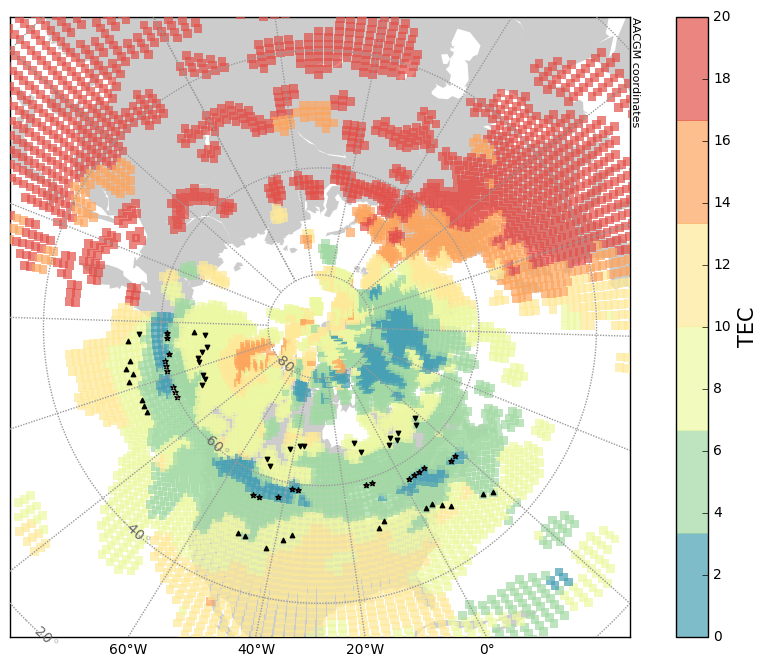

In [10]:
# set colorbar
seaMap = ListedColormap(sns.color_palette("Spectral_r"))
# flatui = ["#3182bd", "#9ecae1", "#7fcdbb", "#ffeda0", "#feb24c", "#f03b20"]
# sns.set_palette(flatui)
# seaMap = ListedColormap( sns.color_palette() )
# Plot map
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
m1 = utils.plotUtils.mapObj(boundinglat=30., gridLabels=True, coords=anlyzCoords, ax=ax, datetime=selDT)
xVec, yVec = m1(list(selTecDF["Mlon"]), list(selTecDF["Mlat"]), coords=anlyzCoords)
# BND data
xVecEquBnd, yVecEquBnd = m1(list(trghBndDF["BndMlon"]), list(trghBndDF["BndEquMlat"]), coords="mag")
xVecPolBnd, yVecPolBnd = m1(list(trghBndDF["BndMlon"]), list(trghBndDF["BndPolMlat"]), coords="mag")
xVecMinTrghBnd, yVecMinTrghBnd = m1(list(trghBndDF["BndMlon"]), list(trghBndDF["minTecMlat"]), coords="mag")
tecPlot = m1.scatter( xVec, yVec , c=selTecDF["med_tec"], s=40.,\
           cmap=seaMap, alpha=0.7, zorder=5., \
                     edgecolor='none', marker="s", vmin=0., vmax=20. )

eqPlot = m1.scatter( xVecEquBnd, yVecEquBnd , s=10.,\
                     c='k', marker="^", zorder=7. )
poPlot = m1.scatter( xVecPolBnd, yVecPolBnd , s=10.,\
                     c='k', marker="v", zorder=7. )
mtPlot = m1.scatter( xVecMinTrghBnd, yVecMinTrghBnd , s=15.,\
                     c='r', marker="*", zorder=7. )

cbar = plt.colorbar(tecPlot, orientation='vertical')
cbar.set_label('TEC', size=15)

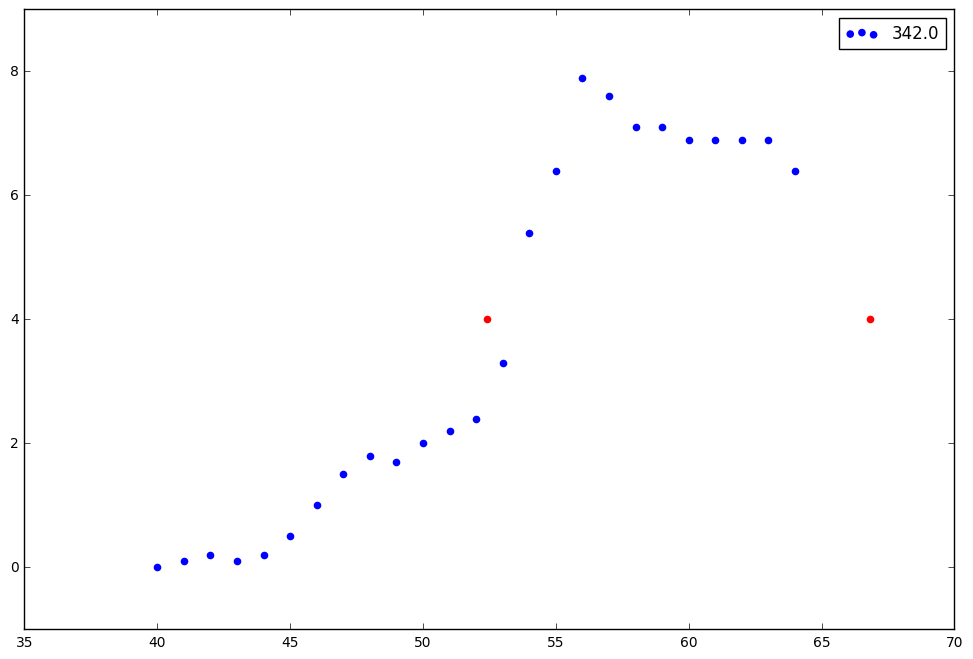

In [14]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
colorList = [ "b", "r", "k" ]
# selMlonList = [ 260., 280., 300., 320., 340., 0., 18. ]
selMlonList = [ 342. ]
for ind, sMlon in enumerate(selMlonList):
    if sMlon < 0.:
        sMlon = sMlon + 360.
    selMlonDF = selTecDF[ (selTecDF["Mlon"] == sMlon) &\
                          (selTecDF["Mlat"] >= equTrghCutoffMLat) &\
                          (selTecDF["Mlat"] <= polTrghCutoffMLat)]
    # If no significant number of values are found discard
    if len( selMlonDF["med_tec"].values ) < 5.:
        continue
    tecGaussFitArr = numpy.max( selMlonDF["med_tec"].values ) - selMlonDF["med_tec"].values
    mlatPltArr = numpy.arange(equTrghCutoffMLat-20, polTrghCutoffMLat+20)
    popt, pcov = curve_fit(gauss_function, selMlonDF["Mlat"].values,\
                           tecGaussFitArr, p0 = [2, 52., 1.])
    fwhmEqu = popt[1] - popt[2]*2.355/2.
    fwhmPol = popt[1] + popt[2]*2.355/2.
    tecValFwhmEqu = gauss_function(fwhmEqu, *popt)
    tecValFwhmPol = gauss_function(fwhmPol, *popt)
    # Test goodness of fit
    ksTestTecArr = numpy.array( [ gauss_function(l, *popt)\
                                for l in selMlonDF["Mlat"].values.tolist() ] )
    ksDStat, ksPVal = stats.ks_2samp( tecGaussFitArr, ksTestTecArr )
    # we setup a few conditions to discard bad fits
    # 1) location of trough min should be between 45 nad 65 MLAT
    if ((popt[1] > cutOffTrghMinUpper)\
            | (popt[1] < cutOffTrghMinLower)):
        print "hey111"
        continue
    # 2) if percent error in any of fit parameters is more 
    # than 10 % (cutoff) then skip
    if ( ( pcov[0,0]**0.5/popt[0] > cutOffPrcntErrorFit  ) \
        | ( pcov[1,1]**0.5/popt[1] > cutOffPrcntErrorFit  ) \
        | ( pcov[2,2]**0.5/popt[2] > cutOffPrcntErrorFit  ) ):
        print "hey111222"
        continue
    # 3) Number of latitudes should be greater than 20.
    if len( selMlonDF["Mlat"].values ) < cutOffLatCnt:
        print "hey333"
        continue
    # 4) If p-val from the KS TEST is low discard
    # or if KS Stat is high discard
    if ksPVal < cutoffKSPval:
        print "hey444"
        continue
    if ksDStat > cutoffKSDstat:
        print "hey111444bbb"
        continue
    # 5) if tec value at min trough is greater than 4.
    # discard
    # GET Trough min loc and tec val
    minTrghLoc = min(list(selMlonDF["Mlat"].values), key=lambda x:abs(x-popt[1]))
    minTrghTecVal = selMlonDF[ selMlonDF["Mlat"] == minTrghLoc ]["med_tec"].values[0]
    # GET Trough equ loc and tec val
    equTrghLoc = min(list(selMlonDF["Mlat"].values), key=lambda x:abs(x-fwhmEqu))
    equTrghTecVal = selMlonDF[ selMlonDF["Mlat"] == equTrghLoc ]["med_tec"].values[0]
    # GET Trough pol loc and tec val
    polTrghLoc = min(list(selMlonDF["Mlat"].values), key=lambda x:abs(x-fwhmPol))
    polTrghTecVal = selMlonDF[ selMlonDF["Mlat"] == polTrghLoc ]["med_tec"].values[0]
#     if minTrghTecVal > cutOffMinTECVal:
#         print minTrghTecVal
#         print "hey555"
#         continue
            
    ax.scatter( selMlonDF["Mlat"].values, tecGaussFitArr,label=str(sMlon), color=colorList[ind] )
    ax.scatter( popt[1] - popt[2]*2.355/2., 4., color="r" )
    ax.scatter( popt[1] + popt[2]*2.355/2., 4., color="r" )
ax.legend()
